## 10. Working with Time series

- 참고자료 : https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html

<div style="text-align: right"> Initial upload: 2022.01.06 </div>
<div style="text-align: right"> Last update: 2022.01.06</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 50

판다스는 financial modeling을 위해 개발된 것이다.

### Native Python dates and times: datetime and dateutil

pandas가 date, time을 다룰때 사용하는 오브젝트는 내부에 있는 빌트인 datetime 모듈이다.  
이와 별도로 datatime 모듈도 있다.

In [2]:
from datetime import datetime

In [3]:
datetime(year= 2015, month = 7, day = 4)

datetime.datetime(2015, 7, 4, 0, 0)

dateutil 모듈로 파싱도 가능하다.

In [4]:
from dateutil import parser
date = parser.parse("4th of July, 2015")
date

datetime.datetime(2015, 7, 4, 0, 0)

datetime 객체를 구했으면 아래와 같이 요일도 추출가능



In [5]:
date.strftime('%A')

'Saturday'

### Typed arrays of times: NumPy's datetime64

numpy에서는 native time series type이 있다. `datetime64`, 이 것은 64비트 정수를 사용한다. 따라서 날짜를 매우 정교하게 표현할 수 있다.  
이 포맷은 교유의 포맷이 있다.

In [6]:
import numpy as np

In [7]:
date = np.array('2015-07-04', dtype = np.datetime64)

In [8]:
date

array('2015-07-04', dtype='datetime64[D]')

이포맷을 구축하면 vectorized 연산이 가능하다.



In [10]:
date + np.arange(12)

array(['2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
       '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
       '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15'],
      dtype='datetime64[D]')

ne detail of the datetime64 and timedelta64 objects is that they are built on a fundamental time unit. Because the datetime64 object is limited to 64-bit precision, the range of encodable times is 264 times this fundamental unit. In other words, datetime64 imposes a trade-off between time resolution and maximum time span.

For example, if you want a time resolution of one nanosecond, you only have enough information to encode a range of 264 nanoseconds, or just under 600 years. NumPy will infer the desired unit from the input; for example, here is a day-based datetime:

In [11]:
np.datetime64('2015-07-04')

numpy.datetime64('2015-07-04')

In [12]:
np.datetime64('2015-07-04 12:00')


numpy.datetime64('2015-07-04T12:00')

In [13]:
np.datetime64('2015-07-04 12:59:59.50', 'ns')

numpy.datetime64('2015-07-04T12:59:59.500000000')

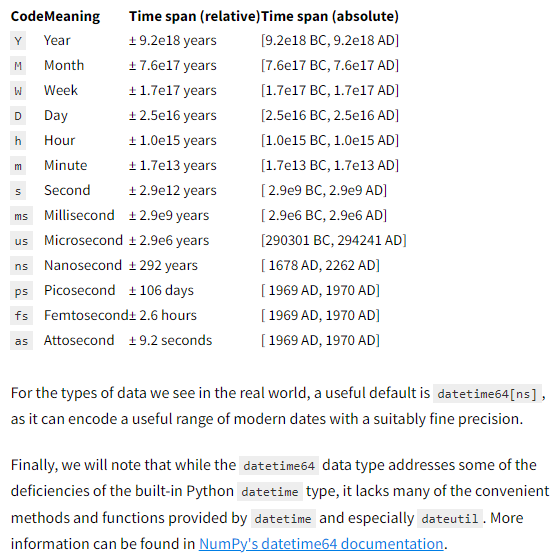

### Dates and times in pandas: best of both worlds

Pandas builds upon all the tools just discussed to provide a Timestamp object, which combines the ease-of-use of datetime and dateutil with the efficient storage and vectorized interface of numpy.datetime64. From a group of these Timestamp objects, Pandas can construct a DatetimeIndex that can be used to index data in a Series or DataFrame; we'll see many examples of this below.

In [14]:
import pandas as pd

In [15]:
date = pd.to_datetime('4th of july, 2015')

In [16]:
date

Timestamp('2015-07-04 00:00:00')

In [17]:
date.strftime('%A')

'Saturday'

vectorized operations

In [18]:
date + pd.to_timedelta(np.arange(12), 'D')

DatetimeIndex(['2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
               '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
               '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15'],
              dtype='datetime64[ns]', freq=None)

### Resampling, Shifting, and Windowing

In [19]:
!pip install pandas-datareader

In [20]:
from pandas_datareader import data

In [23]:
goog = data.DataReader(name= 'GOOG', start='2004', end='2016', data_source = 'yahoo')

In [24]:
goog.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2004-08-19,51.835709,47.800831,49.813290,49.982655,44871361.0,49.982655
2004-08-20,54.336334,50.062355,50.316402,53.952770,22942874.0,53.952770
2004-08-23,56.528118,54.321388,55.168217,54.495735,18342897.0,54.495735
2004-08-24,55.591629,51.591621,55.412300,52.239197,15319808.0,52.239197
2004-08-25,53.798351,51.746044,52.284027,52.802086,9232276.0,52.802086


In [26]:
goog = goog['Close']

<AxesSubplot:xlabel='Date'>

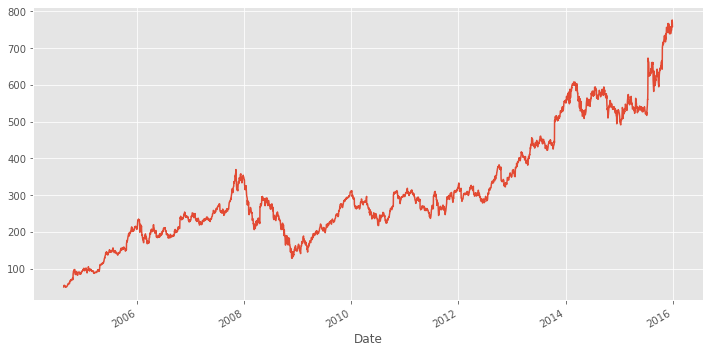

In [28]:
goog.plot(figsize = (12, 6))

### Resampling and converting frequencies

resample은 data aggregation이고 asfreq는 data selection이다.

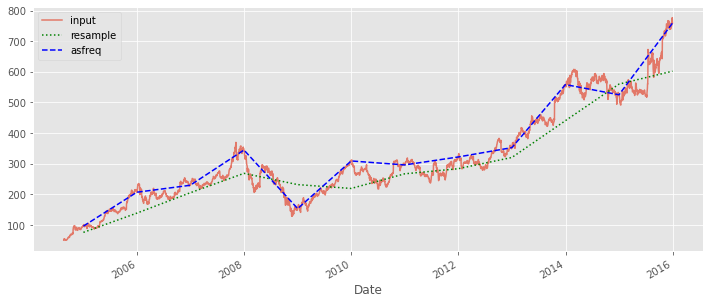

In [33]:
plt.figure(figsize=(12, 5))
goog.plot(alpha=0.7, style='-')
goog.resample('BA').mean().plot(style=':', color = 'g') # Business year end
goog.asfreq('BA').plot(style='--', color = 'b');
plt.legend(['input', 'resample', 'asfreq'], loc='upper left');

- resample은 이전 년도의 평균  
- asfreq는 마지막 년도의 값

업샘플링시에는 resample, asfreq가 같다. 하지만 resample이 옵션이 많다.....

For up-sampling, resample() and asfreq() are largely equivalent, though resample has many more options available. In this case, the default for both methods is to leave the up-sampled points empty, that is, filled with NA values. Just as with the pd.fillna() function discussed previously, asfreq() accepts a method argument to specify how values are imputed. Here, we will resample the business day data at a daily frequency (i.e., including weekends):

In [37]:
goog.iloc[:10]

Date
2004-08-19    49.982655
2004-08-20    53.952770
2004-08-23    54.495735
2004-08-24    52.239197
2004-08-25    52.802086
2004-08-26    53.753517
2004-08-27    52.876804
2004-08-30    50.814533
2004-08-31    50.993862
2004-09-01    49.937820
Name: Close, dtype: float64

- 중간중간 휴일 공백이 있다.

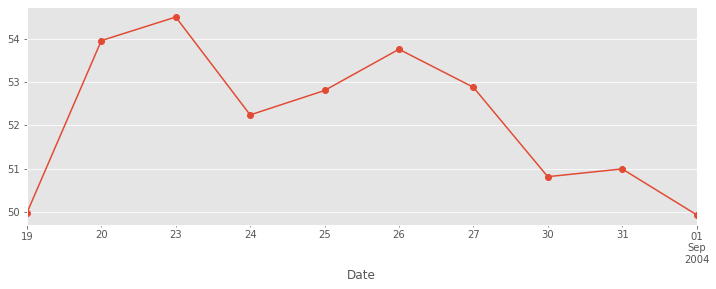

In [38]:
data = goog.iloc[:10].plot(marker = 'o', figsize = (12, 4))

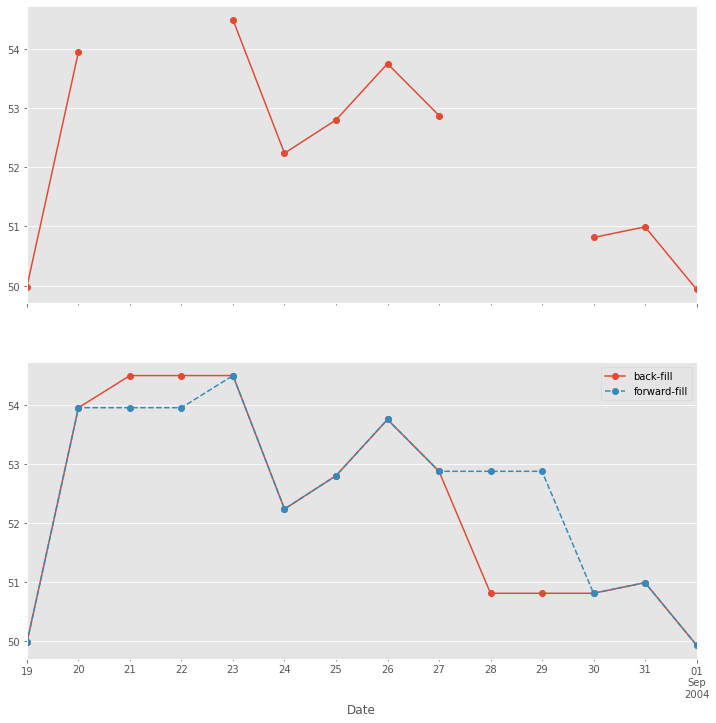

In [40]:
fig, ax = plt.subplots(2, figsize = (12, 12), sharex=True)

data = goog.iloc[:10]
data.asfreq('D').plot(ax = ax [0], marker = 'o')

data.asfreq('D', method='bfill').plot(ax=ax[1], style='-o')
data.asfreq('D', method='ffill').plot(ax=ax[1], style='--o')
ax[1].legend(["back-fill", "forward-fill"]);

**중요 asfreq를 결측날짜 확인에 사용할 것!!!**

### Time shifts

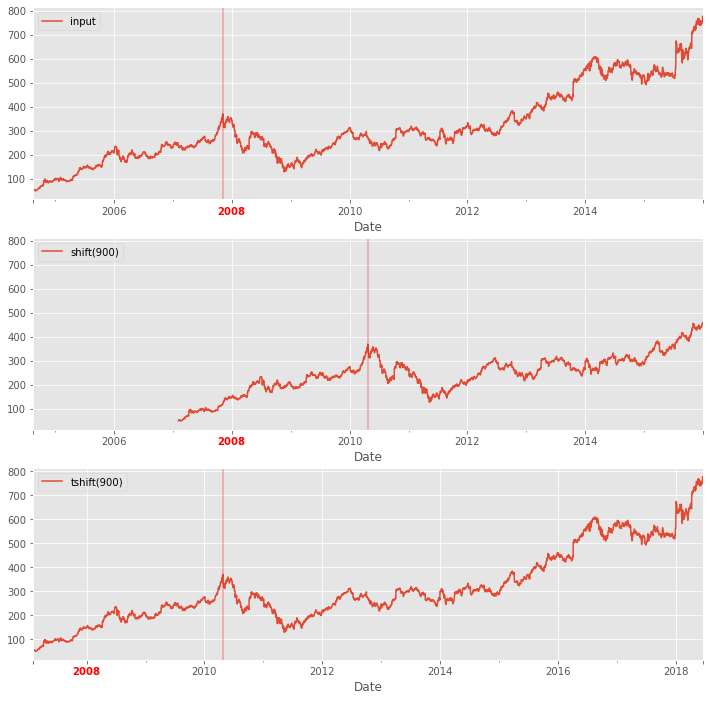

In [41]:
fig, ax = plt.subplots(3, sharey=True, figsize = (12, 12))

# apply a frequency to the data
goog = goog.asfreq('D', method='pad')

goog.plot(ax=ax[0])
goog.shift(900).plot(ax=ax[1])
goog.tshift(900).plot(ax=ax[2])

# legends and annotations
local_max = pd.to_datetime('2007-11-05')
offset = pd.Timedelta(900, 'D')

ax[0].legend(['input'], loc=2)
ax[0].get_xticklabels()[2].set(weight='heavy', color='red')
ax[0].axvline(local_max, alpha=0.3, color='red')

ax[1].legend(['shift(900)'], loc=2)
ax[1].get_xticklabels()[2].set(weight='heavy', color='red')
ax[1].axvline(local_max + offset, alpha=0.3, color='red')

ax[2].legend(['tshift(900)'], loc=2)
ax[2].get_xticklabels()[1].set(weight='heavy', color='red')
ax[2].axvline(local_max + offset, alpha=0.3, color='red');

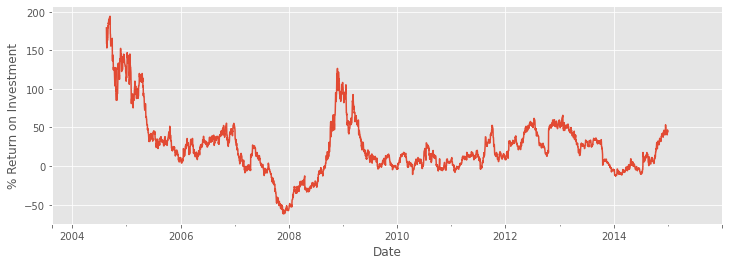

In [42]:
ROI = 100 * (goog.tshift(-365) / goog - 1)
ROI.plot(figsize = (12, 4))
plt.ylabel('% Return on Investment');

### Rolling windows

1year centered rolling mean

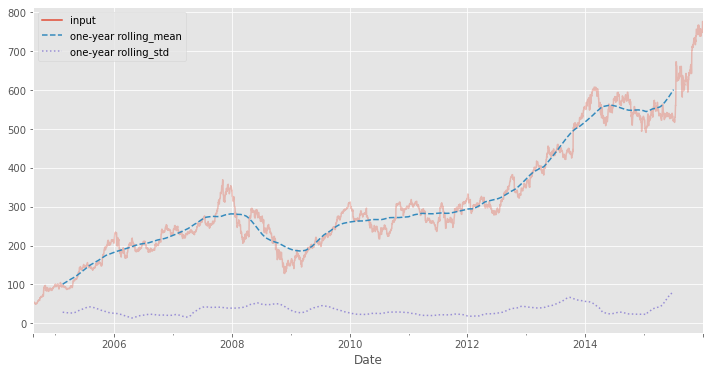

In [43]:
rolling = goog.rolling(365, center=True)

data = pd.DataFrame({'input': goog,
                     'one-year rolling_mean': rolling.mean(),
                     'one-year rolling_std': rolling.std()})
ax = data.plot(style=['-', '--', ':'], figsize = (12, 6))
ax.lines[0].set_alpha(0.3)